### Import required libraries

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inventorize3 as inv

### Loding dataset

In [46]:
data_path = './data/data.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

### Data Preprocessing

In [47]:
print("Initial data shape:", data.shape)
print(f"Total records before preprocessing: {len(data):,}")
print("\nMissing values before handling:")
print(data.isnull().sum())

# Track changes in data
preprocessing_summary = {
    'Initial records': len(data)
}

# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])
preprocessing_summary['After dropping missing CustomerID'] = len(data)

# Fill missing Description values
data['Description'].fillna("Unknown", inplace=True)

# Convert data types
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['CustomerID'] = data['CustomerID'].astype(int)

# Remove duplicates
duplicates_count = data.duplicated().sum()
data = data.drop_duplicates()
preprocessing_summary['After removing duplicates'] = len(data)

print("\nPreprocessing Summary:")
print("-" * 50)
previous_count = preprocessing_summary['Initial records']
for step, count in preprocessing_summary.items():
    records_removed = previous_count - count
    percentage_change = (records_removed / previous_count) * 100
    print(f"{step}: {count:,} records")
    if step != 'Initial records':
        print(f"Records removed: {records_removed:,} ({percentage_change:.2f}%)")
    previous_count = count

print("\nFinal data shape:", data.shape)
print("Missing values after handling:")
print(data.isnull().sum())

Initial data shape: (541909, 8)
Total records before preprocessing: 541,909

Missing values before handling:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


C:\Users\aryan\AppData\Local\Temp\ipykernel_4800\1550152774.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Description'].fillna("Unknown", inplace=True)



Preprocessing Summary:
--------------------------------------------------
Initial records: 541,909 records
After dropping missing CustomerID: 406,829 records
Records removed: 135,080 (24.93%)
After removing duplicates: 401,604 records
Records removed: 5,225 (1.28%)

Final data shape: (401604, 8)
Missing values after handling:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


### Create a Revenue column (Revenue = Quantity * UnitPrice)

In [48]:
data['Revenue'] = data['Quantity'] * data['UnitPrice']

### ABC Analysis based on Quantity (Volume)

In [49]:
abc_quantity = inv.ABC(data[['Description', 'Quantity']])
print("\nABC classification based on Quantity:")
quantity_counts = abc_quantity.Category.value_counts()
quantity_percentages = abc_quantity.Category.value_counts(normalize=True) * 100
print("\nQuantity-based classification distribution:")
for category in ['A', 'B', 'C']:
    if category in quantity_counts:
        print(f"Category {category}: {quantity_counts[category]:,} items ({quantity_percentages[category]:.1f}%)")



ABC classification based on Quantity:

Quantity-based classification distribution:
Category A: 103,547 items (25.8%)
Category B: 81,161 items (20.2%)
Category C: 216,896 items (54.0%)


In [50]:
# Analysis of Quantity-based ABC Classification
print("\nAnalysis of Quantity-based ABC Classification:")
quantity_summary = data.groupby(abc_quantity['Category'])['Quantity'].agg(['sum', 'mean', 'count'])
quantity_summary['percentage'] = quantity_summary['sum'] / quantity_summary['sum'].sum() * 100
print(quantity_summary)



Analysis of Quantity-based ABC Classification:
              sum       mean   count  percentage
Category                                        
A         3914274  37.801906  103547   79.999861
B          733930   9.042890   81161   15.000048
C          244647   1.127946  216896    5.000091


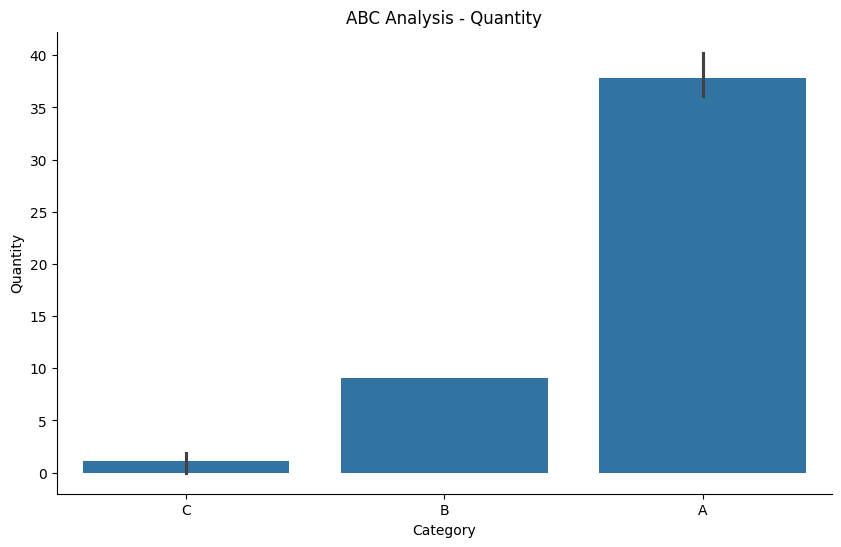

In [51]:
# Visualize ABC classification for Quantity
plt.figure(figsize=(10, 6))
sns.barplot(x=abc_quantity['Category'], y=data['Quantity'])
sns.despine()
plt.title('ABC Analysis - Quantity')
plt.show()

### ABC Analysis based on Revenue

In [52]:
abc_revenue = inv.ABC(data[['Description', 'Revenue']])
print("\nABC classification based on Revenue:")
revenue_counts = abc_revenue.Category.value_counts()
revenue_percentages = abc_revenue.Category.value_counts(normalize=True) * 100
print("\nRevenue-based classification distribution:")
for category in ['A', 'B', 'C']:
    if category in revenue_counts:
        print(f"Category {category}: {revenue_counts[category]:,} items ({revenue_percentages[category]:.1f}%)")



ABC classification based on Revenue:

Revenue-based classification distribution:
Category A: 115,796 items (28.8%)
Category B: 82,102 items (20.4%)
Category C: 203,706 items (50.7%)


In [53]:
# Analysis of Revenue-based ABC Classification
print("\nAnalysis of Revenue-based ABC Classification:")
revenue_summary = data.groupby(abc_revenue['Category'])['Revenue'].agg(['sum', 'mean', 'count'])
revenue_summary['percentage'] = revenue_summary['sum'] / revenue_summary['sum'].sum() * 100
print(revenue_summary)


Analysis of Revenue-based ABC Classification:
                  sum       mean   count  percentage
Category                                            
A         6622812.040  57.193789  115796   79.999958
B         1241780.250  15.124848   82102   15.000028
C          413927.134   2.031983  203706    5.000014


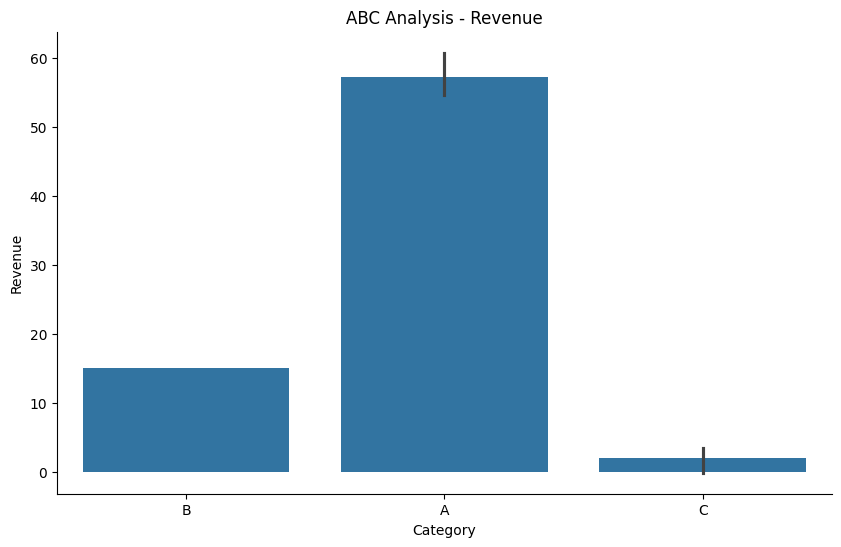

In [54]:
# Visualize ABC classification for Revenue
plt.figure(figsize=(10, 6))
sns.barplot(x=abc_revenue['Category'], y=data['Revenue'])
sns.despine()
plt.title('ABC Analysis - Revenue')
plt.show()

### Multi-Criteria ABC Analysis (Quantity + Revenue)

In [55]:
# Using Description for the join
data_abc = pd.concat([
    abc_quantity[['Description', 'Category']].rename(columns={'Category': 'Category_Quantity'}),
    abc_revenue[['Category']].rename(columns={'Category': 'Category_Revenue'})
], axis=1)

print("\nCombined ABC classification summary:")
combo_summary = pd.crosstab(data_abc['Category_Quantity'], 
                          data_abc['Category_Revenue'], 
                          margins=True)
print("\nQuantity vs Revenue Category Distribution:")
print(combo_summary)


Combined ABC classification summary:

Quantity vs Revenue Category Distribution:
Category_Revenue        A      B       C     All
Category_Quantity                               
A                   56850  19563   27134  103547
B                   33018  25570   22573   81161
C                   25928  36969  153999  216896
All                115796  82102  203706  401604


In [56]:
# Analysis of Combined ABC Classification
combined_summary = data.groupby([
    abc_quantity['Category'], 
    abc_revenue['Category']
])[['Quantity', 'Revenue']].sum()

print("\nDetailed Combined ABC Classification Analysis:")
print(combined_summary)


Detailed Combined ABC Classification Analysis:
                   Quantity      Revenue
Category Category                       
A        A          3012590  4871988.180
         B           360898   293761.960
         C           540786   229712.390
B        A           296078   964814.480
         B           234628   389660.020
         C           203224   168705.310
C        A            97875   786009.380
         B           116735   558358.270
         C            30037    15509.434


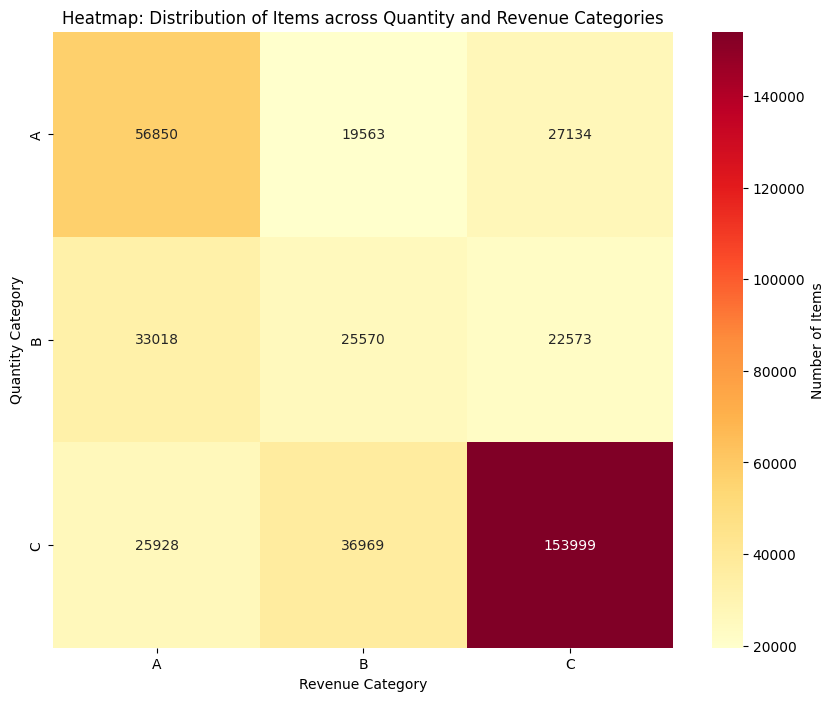

In [57]:
plt.figure(figsize=(10, 8))
combo_summary_no_margins = combo_summary.iloc[:-1, :-1] 
sns.heatmap(combo_summary_no_margins, 
            annot=True, 
            fmt='d', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Number of Items'})
plt.title('Heatmap: Distribution of Items across Quantity and Revenue Categories')
plt.xlabel('Revenue Category')
plt.ylabel('Quantity Category')
plt.show()